# MC dropout

In [1]:
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt


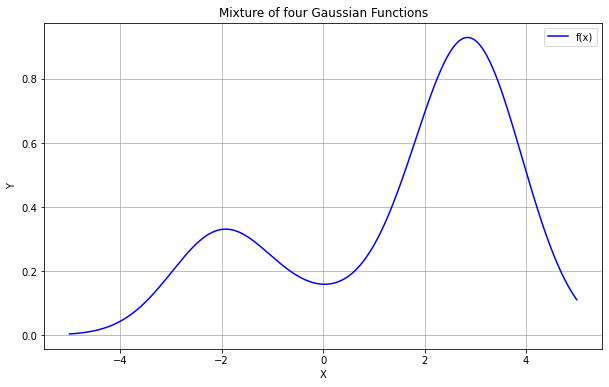

In [2]:
# Define parameters for the three Gaussian components
means = [-2, 0, 3, 2]  # Mean values for the Gaussian components
variances = [1, 1, 1, 1]  # Variance values for the Gaussian components
amplitudes = [0.8, 0.2, 2, 0.5]  # Amplitude values for the Gaussian components

# Convert variance values to tensors
variances = torch.tensor(variances)

# Generate data points
x = torch.linspace(-5, 5, 1000)

# Calculate the probability density function (PDF) for each Gaussian component
pdfs = []
for mean, variance, amplitude in zip(means, variances, amplitudes):
    pdf = amplitude * torch.exp(-0.5 * ((x - mean) / variance)**2) / torch.sqrt(2 * np.pi * variance**2)
    pdfs.append(pdf)

# Combine the PDFs to create the mixture model
mixture_pdf = sum(pdfs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), mixture_pdf.numpy(), label='f(x)', color='blue')
# for mean, variance, amplitude in zip(means, variances, amplitudes):
#     plt.plot(x.numpy(), amplitude * torch.exp(-0.5 * ((x - mean) / variance)**2) / torch.sqrt(2 * np.pi * variance**2),
#              label=f'Gaussian (Mean={mean}, Var={variance}, Amp={amplitude})', linestyle='--')
plt.title('Mixture of four Gaussian Functions')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


# sampling of data

In [3]:
def f(x):
    means = [-2, 0, 3, 2]  # Mean values for the Gaussian components
    variances = [1, 1, 1, 1]  # Variance values for the Gaussian components
    amplitudes = [0.8, 0.2, 2, 0.5]  # Amplitude values for the Gaussian components
    variances = torch.tensor(variances)
    pdfs = []
    for mean, variance, amplitude in zip(means, variances, amplitudes):
        pdf = amplitude * torch.exp(-0.5 * ((x - mean) / variance)**2) / torch.sqrt(2 * np.pi * variance**2)
        pdfs.append(pdf)
    mixture_pdf = sum(pdfs)
    return mixture_pdf


In [4]:
def get_data_samples():
    x = torch.linspace(-5, -0.5, 500)
    x = torch.hstack([x, torch.linspace(0.5, 5, 1000)]) 
    eps = torch.randn_like(x) * 0.1
    f_x = f(x) 
    y = f_x + eps
    y_train = f_x + eps
    x_train = x[:, None]
    return x_train, y_train, f

In [5]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots()

    plt.xlabel("X",)
    plt.ylabel("Y",)

    x_train, y_train, true_func = get_data_samples()
    
    x_all = torch.linspace(-5, 5, 1000)
    
    ax.plot(x_train, y_train, 'C0', marker='o', ms= 4, linestyle='none', alpha=0.2, label='Observations')
    ax.plot(x_all, true_func(x_all), 'C1', linewidth=1, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, frameon=False)
    plt.show()

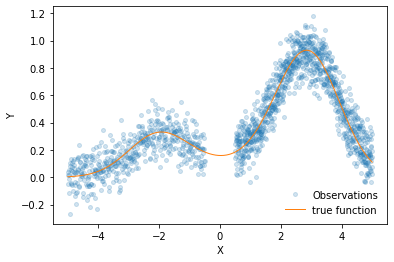

In [6]:
plot_generic()

In [7]:
input_dim = 1

hidden_l1_dim = 100
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [8]:
train_x, train_y, true_func = get_data_samples()
test_x = torch.linspace(-5, 5, 1000)[:, None]

parameters = init_params()


with torch.no_grad():
    y_hat_untrained = mlp(test_x, parameters).ravel()
# Detach and convert to numpy
y_hat_untrained = y_hat_untrained.cpu().detach().numpy()

In [9]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')

    plot_generic(add_predictions)

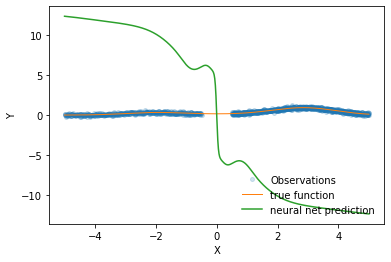

In [10]:
plot_predictions(test_x.cpu(), y_hat_untrained)

In [11]:
def train(params, opt, fwd_func, x_train, y_train, epochs=1000, dropout=False, p=0.0):
    for i in range(epochs):
        y_hat = fwd_func(x_train, params, p)  # Pass the dropout flag and probability to fwd_func
        loss = F.mse_loss(y_hat, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 500 == 0:
            print(f"Epoch {i}, loss {loss.item():.3f}")
    return params
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 2.002
Epoch 500, loss 0.012
Epoch 1000, loss 0.011
Epoch 1500, loss 0.010
Epoch 2000, loss 0.010
Epoch 2500, loss 0.010
Epoch 3000, loss 0.010
Epoch 3500, loss 0.010
Epoch 4000, loss 0.010
Epoch 4500, loss 0.010
Epoch 5000, loss 0.010
Epoch 5500, loss 0.010


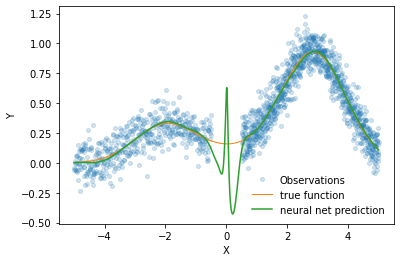

In [12]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

# MC-dropout

In [13]:
def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #h2 = torch.sin(h1 @ W2 + b2)
    #h3 = h2 @ W3 + b3
    #return h3
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h1) > p
        h1 = h1 * mask
        # scale activations to account for dropout
        h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        h2 = h2 / (1 - p)
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [14]:
p = 0.1
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-3)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=10000, dropout=True, p=p)

Epoch 0, loss 22.828
Epoch 500, loss 2.050
Epoch 1000, loss 0.462
Epoch 1500, loss 0.092
Epoch 2000, loss 0.052
Epoch 2500, loss 0.050
Epoch 3000, loss 0.050
Epoch 3500, loss 0.048
Epoch 4000, loss 0.040
Epoch 4500, loss 0.031
Epoch 5000, loss 0.028
Epoch 5500, loss 0.026
Epoch 6000, loss 0.024
Epoch 6500, loss 0.022
Epoch 7000, loss 0.020
Epoch 7500, loss 0.019
Epoch 8000, loss 0.019
Epoch 8500, loss 0.017
Epoch 9000, loss 0.017
Epoch 9500, loss 0.016


In [15]:

# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

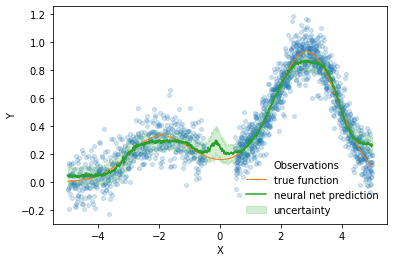

In [16]:
# Plot mean and variance of MC dropout predictions
preds = np.array(preds)
mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x, mean, std)

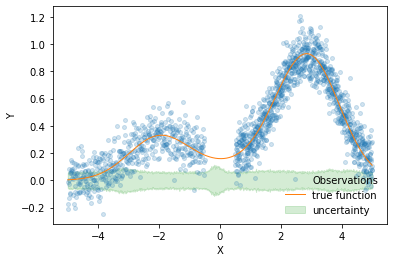

In [17]:
# Just plot the uncertainty

def plot_uncertainty(x_test, y_std):
    def add_predictions(ax):
        ax.fill_between(x_test.ravel(), -y_std, y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)
    
plot_uncertainty(test_x, std)

# MC-dropout with residual connections

In [18]:
### Rewriting the model with dropout

input_dim = 1

hidden_l1_dim = 30
hidden_l2_dim = 30

def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True))
    return [W1, b1, W2, b2, W3, b3]

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        h2 = h2 / (1 - p)
    # add residual connection
    h2 = h2 + h1
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [20]:
# Train the model
p = 0.2
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=1e-3)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=10000, dropout=True, p=p)

Epoch 0, loss 10.206
Epoch 500, loss 0.442
Epoch 1000, loss 0.104
Epoch 1500, loss 0.049
Epoch 2000, loss 0.034
Epoch 2500, loss 0.023
Epoch 3000, loss 0.019
Epoch 3500, loss 0.017
Epoch 4000, loss 0.016
Epoch 4500, loss 0.015
Epoch 5000, loss 0.014
Epoch 5500, loss 0.013
Epoch 6000, loss 0.014
Epoch 6500, loss 0.013
Epoch 7000, loss 0.013
Epoch 7500, loss 0.012
Epoch 8000, loss 0.012
Epoch 8500, loss 0.012
Epoch 9000, loss 0.012
Epoch 9500, loss 0.012


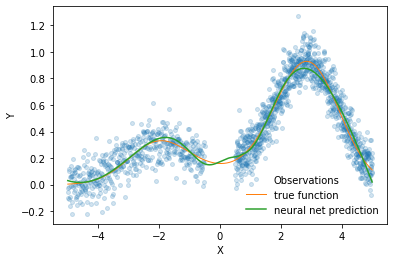

In [22]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x, y_hat_dropout)

In [23]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

preds = np.array(preds)
preds.shape

(100, 1000)

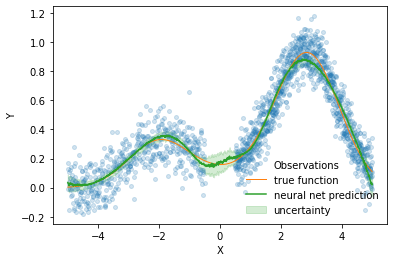

In [24]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x, mean, std)